In [2]:
import tensorflow as tf
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import os

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class convolution:
    
    def __init__(self,in_channel,ot_channel,kernel_size,strides):
        
        self.in_channel = in_channel//4
        self.ot_channel = ot_channel//4
        self.weight_size = [self.ot_channel,self.in_channel,kernel_size,kernel_size]
        self.kernel  = (kernel_size,kernel_size)
        self.kernel_size  =  kernel_size
        self.stride  =  strides
             
        #initialize the weights
        self.glorat_normal =  1./np.sqrt(2*(self.in_channel+self.ot_channel))
        self.r_weight  =  tf.random_normal(self.weight_size,stddev=self.glorat_normal)
        self.i_weight  = tf.random_normal(self.weight_size,stddev=self.glorat_normal)
        self.j_weight  =  tf.random_normal(self.weight_size,stddev=self.glorat_normal)
        self.k_weight  =  tf.random_normal(self.weight_size,stddev=self.glorat_normal)
        
        
        
     
        
    def conv2D(self,x):
        
        qr_kernelR = tf.concat([self.r_weight,-self.i_weight,-self.j_weight,-self.k_weight],axis=1)
        qr_kerneli = tf.concat([self.i_weight,self.r_weight,-self.j_weight,self.k_weight],axis=1)
        qr_kernelj = tf.concat([self.j_weight,self.i_weight,self.r_weight,-self.k_weight],axis=1)
        qr_kernelk = tf.concat([self.k_weight,-self.i_weight,self.j_weight,self.r_weight],axis=1)
        
        weight =tf.concat([qr_kernelR,qr_kerneli,qr_kernelj,qr_kernelk],axis=0)
        
        
        
        
        weight  = tf.reshape(weight,(weight.shape[3],weight.shape[2],weight.shape[1],weight.shape[0]))
        
        weight  = tf.Variable(weight)
      
        bias= tf.random_uniform([weight.shape[3].value])
              
        
        Z = tf.nn.conv2d(x,weight,strides=[1,2,2,1],padding="SAME")
       
        Z = tf.layers.batch_normalization(Z,trainable=True,momentum=0.1)
        
        Z = tf.add(Z,bias)
        
        output  = tf.nn.sigmoid(Z)
        
        return output
    
    
    def calculateOutputShape(self,input_shape,stride,kernel_size):
        
        x =  (input_shape -1)*stride +2
        return x.value

    
    def conv2DTranspose(self,x):
        
        qr_kernelR = tf.concat([self.r_weight,-self.i_weight,-self.j_weight,-self.k_weight],axis=1)
        qr_kerneli = tf.concat([self.i_weight,self.r_weight,-self.j_weight,self.k_weight],axis=1)
        qr_kernelj = tf.concat([self.j_weight,self.i_weight,self.r_weight,-self.k_weight],axis=1)
        qr_kernelk = tf.concat([self.k_weight,-self.i_weight,self.j_weight,self.r_weight],axis=1)
        
        weight = tf.concat([qr_kernelR,qr_kerneli,qr_kernelj,qr_kernelk],axis=0)
        weight  = tf.reshape(weight,(weight.shape[3],weight.shape[2],weight.shape[0],weight.shape[1]))
        
        weight  =  tf.Variable(weight)
        
        #H1(input_size)*stride  if padding == SAME
    
        H1  = [1,self.calculateOutputShape(x.shape[1],self.stride,self.kernel_size),self.calculateOutputShape(x.shape[2],self.stride,self.kernel_size),weight.shape[2].value]
        
        Z = tf.nn.conv2d_transpose(x,weight,strides=[1,2,2,1],output_shape=H1,padding="SAME")
       
        Z = tf.layers.batch_normalization(Z,trainable=True,momentum=0.1)
        bias  =  tf.random_normal([weight.shape[2].value])        
        Z  = tf.add(Z,bias)

        output = tf.nn.sigmoid(Z)
     
        return output
    
    
    @staticmethod
    def forwardModel(x):
        #encoder
        cnv = convolution(4,32,3,2)
        output1  = cnv.conv2D(x)
        
      
        cnv =  convolution(32,64,3,2)
        output2 = cnv.conv2D(output1)
       
        #decoder
        cnv =  convolution(64,32,3,2)
        output3 = cnv.conv2DTranspose(output2)
      
        cnv =  convolution(32,4,3,2)
        y = cnv.conv2DTranspose(output3)
       
        return y

    


        
        

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
from PIL import Image
size = 400
def train_data(path):
    train_original = Image.open(path)
    train_original = train_original.resize((size,size))
    train_original = np.array(train_original)
    train_original = rgb2gray(train_original)


    train = np.zeros((size,size,4))
    train[:,:,0]= np.zeros(size)
    train[:,:,1]= train_original
    train[:,:,2]= train_original
    train[:,:,3]= train_original
    train = np.expand_dims(train,0)

    train = train.astype('float32')
    train /= 255
    
    return train


def test_data(path):
    test_original = Image.open(path)
    test_original = test_original.resize((size,size))
    test_original = np.asarray(test_original)

    test = np.zeros((size,size,4))
    test[:,:,0]= np.zeros(size)
    test[:,:,1]= test_original[:,:,0]
    test[:,:,2]= test_original[:,:,1]
    test[:,:,3]= test_original[:,:,2]
    test = np.expand_dims(test,0)

    test = test.astype('float32')

    test /=  255
    return test,test_original

X  = tf.placeholder('float32',[None,size,size,4])
Y  = tf.placeholder('float32',[None,size,size,4])
                    

In [14]:
def evaluation(test_output,test_original):
    sess = tf.Session()
    
    psnr = sess.run(tf.image.psnr(np.squeeze(test_output,0)[:,:,1:],test_original/255,max_val=1))
    ssim = sess.run(tf.image.ssim(tf.convert_to_tensor(np.squeeze(test_output,0)[:,:,1:]),tf.convert_to_tensor(test_original.astype('float32')/255),max_val=1))
    
    print("PSNR signal to noise Ratio "+str(psnr))
    print("SSIM Structural Similarities Index Method "+str(ssim))
    print("--------------------------------------------------------")
    sess.close()
    
    return psnr,ssim
    
    
psnr_ = []
ssim_ = []
def plottingLoss(loss,psnr_,ssim_):
    x,y = zip(*loss_to_epoch.items())
    plt.plot(x,y)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    plt.plot(psnr_)
    
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.title("PSNR")
    plt.show()
    
    plt.plot(ssim_)
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.title("SSIM")
    plt.show()
    
    
def plottingTestImages(test_images_):
    
    for image in test_images_.values():
        
        test_original = image[0]
        test_output   = image[1]
        
        plt.imshow(np.squeeze(test_output,0)[:,:,1:])
        plt.show()
        plt.imshow(test_original)
        plt.show()
        
   
    
    
    
    
    
    
    


In [15]:
# forward output 
pred = convolution.forwardModel(X)

#MSE
loss  =  tf.losses.mean_squared_error(Y,pred)
optimizer =  tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [16]:
threshold_psnr_min = 100
threshold_psnr_max = -1

threshold_ssim_min = 100
threshold_ssim_max = -100

psnr_ssim = [threshold_psnr_min,threshold_psnr_max,threshold_ssim_min,threshold_ssim_max]


test_images_ = {}


def createImageData(data,type,name,test_original,test_output,choice):
    if type == "min":
        if psnr_ssim[choice] > data:
                psnr_ssim[choice] = data
                test_images_[name]= [test_original,test_output]
        
    elif type == "max":
         if  psnr_ssim[choice]  < data:
                psnr_ssim[choice]  = data
                test_images_[name]= [test_original,test_output]

PSNR signal to noise Ratio 11.152174
SSIM Structural Similarities Index Method 0.35476434
--------------------------------------------------------
PSNR signal to noise Ratio 12.658706
SSIM Structural Similarities Index Method 0.5190989
--------------------------------------------------------
PSNR signal to noise Ratio 14.995834
SSIM Structural Similarities Index Method 0.629482
--------------------------------------------------------
PSNR signal to noise Ratio 15.501528
SSIM Structural Similarities Index Method 0.49794754
--------------------------------------------------------
PSNR signal to noise Ratio 13.627784
SSIM Structural Similarities Index Method 0.54311687
--------------------------------------------------------
PSNR signal to noise Ratio 10.153313
SSIM Structural Similarities Index Method 0.45161295
--------------------------------------------------------
PSNR signal to noise Ratio 11.046205
SSIM Structural Similarities Index Method 0.39876166
-------------------------------

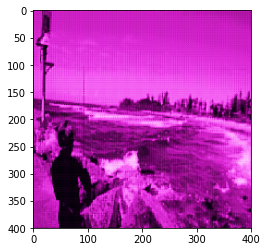

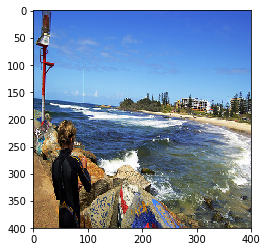

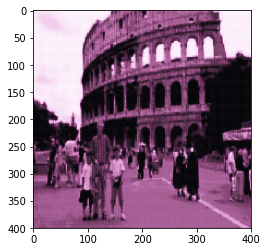

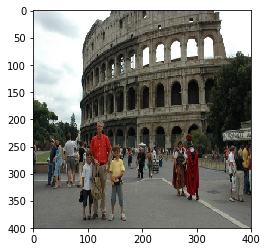

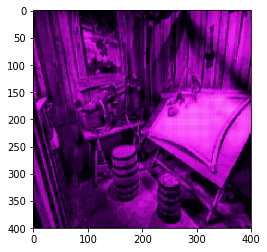

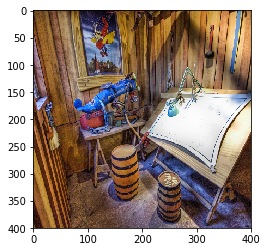

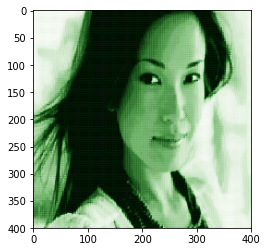

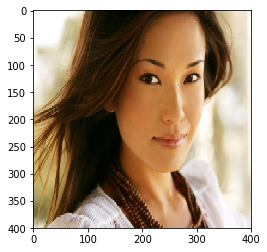

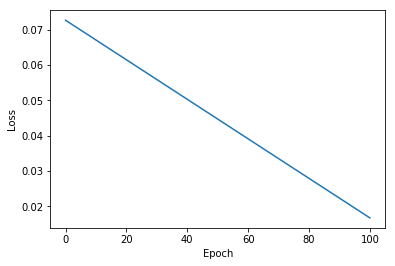

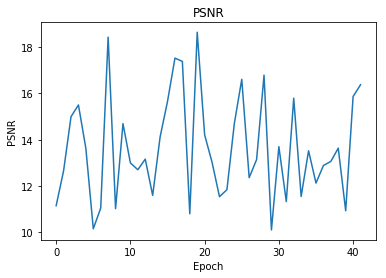

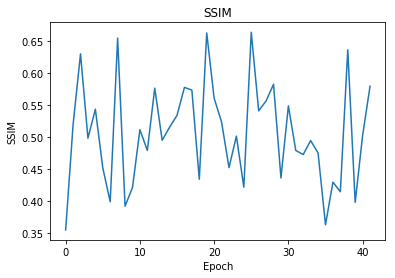

In [17]:
init =  tf.global_variables_initializer()
batch_size = 32
choice = 1
total_images = len(os.listdir("dataset/"))
images   = os.listdir("dataset/")
loss_to_epoch  = {}
y_predict = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(200):
        
        running_batch =  int(total_images/batch_size)
        
        for j in range(running_batch):
            
            names  = images[j:batch_size+j]
           
            for name in names:
       
                if name.endswith("png"):
                    train = train_data("dataset/"+name)
                    loss_value,opt = sess.run([loss,optimizer],feed_dict={X:train,Y:train})
        #                 train_output = sess.run(pred,feed_dict={X:train})
        if i % 100 ==0:
            loss_to_epoch[i] = loss_value
            
    
     
    testData  =  os.listdir("test/")
    
    for name in testData:
        
        if name.endswith("png"):

            test,test_original = test_data("test/"+name)
            test_output =  sess.run(pred,feed_dict={X:test})
            psnr,ssim = evaluation(test_output,test_original)
            psnr_.append(psnr)
            ssim_.append(ssim)
            #PSNR min and max

            createImageData(psnr,"min","psnrmin",test_original,test_output,0)
            createImageData(psnr,"max","psnrmax",test_original,test_output,1)

            #SSIM min and max

            createImageData(ssim,"min","ssimin",test_original,test_output,2)
            createImageData(ssim,"max","ssimax",test_original,test_output,3)

        
    
    
    plottingTestImages(test_images_)
    plottingLoss(loss_to_epoch,psnr_,ssim_)
    
    
    
    
        
        

    

